# Project Setup

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/data/imagenet-1k-valid.zip" "/content"
!unzip "/content/imagenet-1k-valid.zip" -d "/content/imagenet"

Streaming output truncated to the last 5000 lines.
  inflating: /content/imagenet/00900/054653537039094.jpg  
  inflating: /content/imagenet/00900/07272256002875288.jpg  
  inflating: /content/imagenet/00900/075874938728387464.jpg  
  inflating: /content/imagenet/00900/084355288443908.jpg  
  inflating: /content/imagenet/00900/0938813935621416.jpg  
  inflating: /content/imagenet/00900/1655568257304816.jpg  
  inflating: /content/imagenet/00900/17337161967825.jpg  
  inflating: /content/imagenet/00900/185287956232336.jpg  
  inflating: /content/imagenet/00900/1898108151581965.jpg  
  inflating: /content/imagenet/00900/204089788662087.jpg  
  inflating: /content/imagenet/00900/2464974905916646.jpg  
  inflating: /content/imagenet/00900/262262197475642.jpg  
  inflating: /content/imagenet/00900/2677013029370365.jpg  
  inflating: /content/imagenet/00900/2823587208350367.jpg  
  inflating: /content/imagenet/00900/2846489896468567.jpg  
  inflating: /content/imagenet/00900/300747621842155.

In [ ]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/data/bigearthnet-mini.tar" "/content"
!tar -xf "/content/bigearthnet-mini.tar"

In [ ]:
!pip install pytorch-lightning efficientnet-pytorch timm -q

# Imports & Constants

In [ ]:
import torch
import random
import os
import pandas as pd
from torchvision import models, datasets, transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer, LightningDataModule
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
from efficientnet_pytorch import EfficientNet
from timm import create_model
from PIL import Image

In [ ]:
imagenet_normalization = {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}
trainer = Trainer()
BATCH_SIZE = 32
SMALLER_DATASET = True
NUM_WORKER = 2
GRID_SIZES = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    22,
    33,
    44,
    66,
    112,
    224,
]
MODEL_NAMES = [
    "resnet50",
    "efficientnet-b0",
    "convnext_small",
    "vit_base_patch16_224",
    "swin_base_patch4_window7_224",
]
DATASET_PATHS = ["/content/bigearthnet-mini", "/content/imagenet"]
DATASET_PATHS = ["/content/imagenet"]

# SET SEED
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Grid Shuffle & Datasets

In [ ]:
def grid_shuffle(image, grid_size, resize_to=None):
    if resize_to is not None:
        image = cv2.resize(image, resize_to)

    # Divide the image into a grid
    rows, cols, _ = image.shape
    grid_width = cols // grid_size
    grid_height = rows // grid_size

    # Create a list of grid positions
    grid_positions = [(i, j) for i in range(grid_size) for j in range(grid_size)]

    # Shuffle the grid positions randomly
    np.random.shuffle(grid_positions)

    # Create a new image to store the shuffled grid
    shuffled_image = np.zeros_like(image)

    # Iterate over the grid positions and copy the corresponding grid from the original image to the shuffled image
    for i, (grid_row, grid_col) in enumerate(grid_positions):
        # Calculate the coordinates of the current grid in the original image
        start_row = grid_row * grid_height
        end_row = start_row + grid_height
        start_col = grid_col * grid_width
        end_col = start_col + grid_width

        # Copy the grid from the original image to the shuffled image
        shuffled_image[start_row:end_row, start_col:end_col] = image[
            i // grid_size * grid_height : (i // grid_size + 1) * grid_height,
            i % grid_size * grid_width : (i % grid_size + 1) * grid_width,
        ]

    return shuffled_image


class GridShuffleTransform:
    def __init__(self, grid_size, resize_to=None):
        self.grid_size = grid_size
        self.resize_to = resize_to

    def __call__(self, image):
        # Convert PIL image to NumPy array
        image = np.array(image)
        # Apply grid shuffle
        shuffled_image = grid_shuffle(image, self.grid_size, self.resize_to)
        # Convert NumPy array back to PIL image
        return transforms.functional.to_pil_image(shuffled_image)


class NoOpTransform:
    def __call__(self, image):
        return image

In [ ]:
class BigEarthNetDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.annotations.iloc[index, 1:].to_numpy().astype(float)

        if self.transform:
            image = self.transform(image)

        return image, label


class BigEarthNetDataModule(LightningDataModule):
    def __init__(self, grid_size, batch_size=BATCH_SIZE, data_dir="path/to/BigEarthNet"):
        super().__init__()
        self.batch_size = batch_size
        self.test_csv = f"{data_dir}/splits/test.csv"
        self.root_dir = data_dir
        self.grid_size = grid_size

    def test_dataloader(self):
        transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                GridShuffleTransform(self.grid_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),  # Normalize images
            ]
        )
        test_dataset = BigEarthNetDataset(
            csv_file=self.test_csv, root_dir=self.root_dir, transform=transform
        )

        return DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=NUM_WORKER
        )

In [ ]:
class ImageNetDataModule(LightningDataModule):
    def __init__(self, grid_size, batch_size=BATCH_SIZE, data_dir="path/to/ImageNet"):
        super().__init__()
        self.batch_size = batch_size
        self.data_dir = data_dir
        self.grid_size = grid_size

    def test_dataloader(self):
        transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                GridShuffleTransform(self.grid_size),
                transforms.ToTensor(),
                transforms.Normalize(**imagenet_normalization),
            ]
        )
        test_dataset = datasets.ImageFolder(self.data_dir, transform=transform)
        if SMALLER_DATASET:
            # Sample 10% of images from each class
            sampled_indices = []
            for class_index in range(len(test_dataset.classes)):
                class_indices = [
                    i for i, (_, label) in enumerate(test_dataset.samples) if label == class_index
                ]
                sampled_indices.extend(random.sample(class_indices, len(class_indices) // 10))
            test_dataset = torch.utils.data.Subset(test_dataset, sampled_indices)
        return DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=NUM_WORKER
        )

In [ ]:
def get_dataloader(dataset_path, grid_size):
    if "bigearthnet" in dataset_path:
        data_module = BigEarthNetDataModule(grid_size=grid_size, data_dir=dataset_path)
    elif "imagenet" in dataset_path:
        data_module = ImageNetDataModule(grid_size=grid_size, data_dir=dataset_path)
    else:
        raise ValueError(f"Unknown dataset: {dataset_path}")
    return data_module.test_dataloader()

In [ ]:
def get_pretrained_model(model_name):
    print("loading model", model_name)
    if model_name.startswith("efficientnet"):
        model = EfficientNet.from_pretrained(model_name)
    elif model_name.startswith("resnet"):
        model = getattr(models, model_name)(pretrained=True)
    elif (
        model_name.startswith("convnext")
        or model_name.startswith("vit")
        or model_name.startswith("swin")
    ):
        model = create_model(model_name, pretrained=True)
    else:
        raise ValueError(f"Model {model_name} not supported")
    return model

# Model Tester


In [ ]:
class ModelTester(pl.LightningModule):
    def __init__(self, dataset_path, model, grid_size=1):
        super().__init__()
        self.model = model
        self.data_loader = get_dataloader(dataset_path, grid_size)
        self.test_f1_scores = []  # TODO: calculate f1 & acc globally?
        self.test_accuracies = []
        self.test_outputs = []
        self.all_preds = []
        self.all_labels = []

    def forward(self, x):
        return self.model(x)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = torch.sum(preds == y).float() / len(y)
        f1 = f1_score(y.cpu().numpy(), preds.cpu().numpy(), average="weighted")
        self.all_preds.extend(preds.cpu().numpy())
        self.all_labels.extend(y.cpu().numpy())
        self.log("test_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_f1", f1, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.test_outputs.append({"test_f1": f1, "test_acc": acc.item()})
        return {"test_f1": f1, "test_acc": acc}

    def on_test_epoch_end(self):
        # Compute the average F1 score and accuracy across all test batches
        test_f1_scores = [output["test_f1"] for output in self.test_outputs]
        test_accuracies = [output["test_acc"] for output in self.test_outputs]
        self.final_recall = recall_score(self.all_labels, self.all_preds, average="weighted")
        self.final_precision = precision_score(self.all_labels, self.all_preds, average="weighted")
        self.final_f1 = sum(test_f1_scores) / len(test_f1_scores)
        self.final_acc = sum(test_accuracies) / len(test_accuracies)
        self.test_outputs = []

    def test_dataloader(self):
        return self.data_loader

In [ ]:
def test_models(grid_sizes, models, dataset_paths):
    # print(f"Testing Models {models} with grid_sizes: {grid_sizes}")
    results = pd.DataFrame(
        columns=["Model", "Grid Size", "F1 Score", "Accuracy", "Precision", "Recall"]
    )
    for model_name in models:
        model = get_pretrained_model(model_name)
        for dataset_path in dataset_paths:
            for grid_size in grid_sizes:
                print(f"Testing {model_name} on {dataset_path} with grid size {grid_size}")
                tester = ModelTester(dataset_path, model, grid_size)
                trainer.test(tester)

                results = results.append(
                    {
                        "Dataset": dataset_path,
                        "Model": model,
                        "Grid Size": grid_size,
                        "F1 Score": tester.final_f1,
                        "Accuracy": tester.final_acc,
                        "Precision": tester.final_precision,
                        "Recall": tester.final_recall,
                    },
                    ignore_index=True,
                )
    return results

# Testing

In [ ]:
# test_models([1])
# test_models([4])

### Continuous shuffled

In [ ]:
# Define the grid sizes to test
# GRID_SIZES = [1, 4, 10]
results = test_models(GRID_SIZES, MODEL_NAMES, DATASET_PATHS)

NameError: name 'test_models' is not defined

In [ ]:
results

In [ ]:
# prompt: split the strings of results['Model'] after the first 5 chars

results["Model"] = results["Model"].astype(str)

# Split the 'Model' column at the first '(' and expand the result into two separate columns
split_df = results["Model"].str.split("(", n=1, expand=True)
results["Model"] = split_df[0].str.strip()  # Assign the first part back to the 'Model' column
results

                Model Grid Size  F1 Score  Accuracy  Precision  Recall  \
0              ResNet         1  0.815776  0.749005   0.769934  0.7496   
1              ResNet         2  0.771530  0.691282   0.724307  0.6928   
2              ResNet         3  0.631813  0.539013   0.600368  0.5392   
3              ResNet         4  0.575768  0.482683   0.555820  0.4838   
4              ResNet         6  0.236530  0.174562   0.272812  0.1742   
5              ResNet         8  0.110548  0.078025   0.138390  0.0778   
6              ResNet        10  0.030317  0.022492   0.031515  0.0226   
7              ResNet        12  0.019584  0.013933   0.021202  0.0140   
8              ResNet        14  0.013930  0.010350   0.011640  0.0104   
9              ResNet        16  0.009654  0.007763   0.010404  0.0078   
10             ResNet        20  0.005278  0.004379   0.003631  0.0044   
11       EfficientNet         1  0.811090  0.744029   0.772728  0.7452   
12       EfficientNet         2  0.763

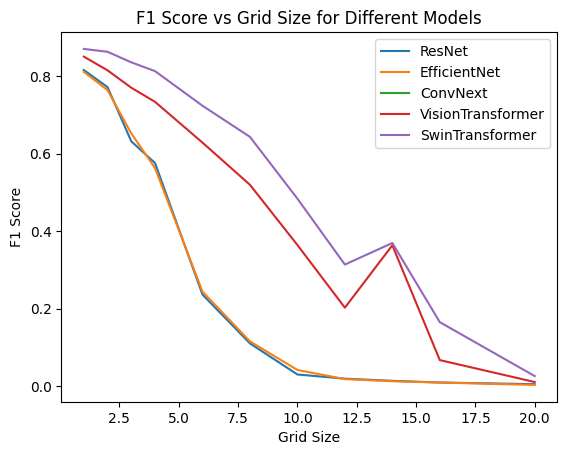

In [ ]:
# prompt: plot the results df with Grid Size as the x-axis, the F1 Score as the y-axis and the Model as the label-name (each with a different color)

import matplotlib.pyplot as plt

# Create a figure and axes object
fig, ax = plt.subplots()
print(results)

# Plot the data for each model
for model_name in ["ResNet", "EfficientNet", "ConvNext", "VisionTransformer", "SwinTransformer"]:
    df_model = results[results["Model"] == model_name]
    print(df_model)
    ax.plot(df_model["Grid Size"], df_model["F1 Score"], label=model_name)

# Set the x-axis label
ax.set_xlabel("Grid Size")

# Set the y-axis label
ax.set_ylabel("F1 Score")

# Set the title
ax.set_title("F1 Score vs Grid Size for Different Models")

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [ ]:
# prompt: plot a graph with grid_size as x axis and the scores for f1 and accuracy as y axis, with dots and interpolating lines

import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the F1 scores and accuracies for each grid size
ax.plot(results["Grid Size"], results["F1 Score"], label="F1 Score", marker="o", linestyle="-")
ax.plot(results["Grid Size"], results["Accuracy"], label="Accuracy", marker="o", linestyle="-")

# Set the labels and title
ax.set_xlabel("Grid Size")
ax.set_ylabel("Score")
ax.set_title("F1 Score and Accuracy vs. Grid Size")

# Add a legend and grid
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

In [ ]:
# prompt: plot f1 scores with grid_size as x axis and model_name as labelname

import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the F1 scores for each model and grid size
for model_name, group in results.groupby("Model"):
    ax.plot(group["Grid Size"], group["F1 Score"], label=model_name, marker="o", linestyle="-")

# Set the labels and title
ax.set_xlabel("Grid Size")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Score vs. Grid Size for Different Models")

# Add a legend and grid
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

# Evaluation

# Data Testing

## Visualise the grid shuffle

In [ ]:
# prompt: open an image from /content/dataset/00001 and pass it to grid shuffle, and visualize once the original and once the shuffled one
image_path = "/content/dataset/00000/013862900598484.jpg"


# Load the image
def visualize_shuffled_images(grid_sizes, image_path):
    image = cv2.imread(image_path)
    plt.figure(figsize=(20, 5))

    for idx, grid_size in enumerate(grid_sizes):
        shuffled_image = grid_shuffle(image, grid_size)
        plt.subplot(1, len(grid_sizes) + 1, idx + 1)
        plt.imshow(shuffled_image)
        plt.title(f"Grid Size: {grid_size}")
    plt.show()


visualize_shuffled_images(GRID_SIZES, image_path)

## Sanity Check that Images are normalized

In [ ]:
# Load your image
from PIL import Image

image = Image.open(image_path)

# Apply the transformation
# Define the normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # This will scale the images to [0, 1]
        normalize,
    ]
)
transformed_image = transform(image)

# Check the range of the transformed image
print("Min value:", transformed_image.min().item())
print("Max value:", transformed_image.max().item())